<a href="https://colab.research.google.com/github/AIWintermuteAI/Bertelsmann-Tech-Scholarship-Challenge-Course---AI-Track-Nanodegree-Program/blob/master/CNN_Pneumonia(Solution).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Pytorch CNN for Medical Image Binary Classification (Normal/Pneumonia)
As I mentioned before, after finishing each lesson in the course I want to explore the lesson topic in depth and publish an exercise/solution notebook. I just finished Lesson 6(Convolutional Neural Networks) and decided to use the knowledge I learned to make a binary classification CNN for detecting pneumonia in chest X-Ray scans.
You are welcome to play around with my solution and find better network architecture/better hyperparameters!

We start by downloading the dataset from Kaggle. There are a few datasets available for pneumonia detection, I decided to choose this one for simplicity - it is a learning exercise afterall.

https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

**Change the Kaggle username and Kaggle API key to the ones from your account**

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = "***" # username from the json file
os.environ['KAGGLE_KEY'] = "***" # key from the json file
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip
!rm -rf chest_xray/__MACOSX chest_xray/chest_xray

 99% 2.28G/2.29G [00:36<00:00, 33.6MB/s]
100% 2.29G/2.29G [00:36<00:00, 66.8MB/s]


We will import the standard dependencies and also download and import barbar - a little utility script that will help us to track the training progress with Keras-like visualization.

https://github.com/yusugomori/barbar

In [0]:
!pip install barbar
from barbar import Bar
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


---
## Creating transform(s) and dataloaders

I would suggest you start with a single transform pipeline for training, validation and test parts of the dataset. When you are satisfied with overall perfomance, it might be a good idea to add image augumentation as well.

In [0]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 2
# how many samples per batch to load
batch_size = 16

transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.Resize(448),
                                 transforms.CenterCrop(448),
                                 transforms.ToTensor()])
train_data = datasets.ImageFolder('chest_xray/train', transform=transform)
valid_data = datasets.ImageFolder('chest_xray/val', transform=transform)
test_data = datasets.ImageFolder('chest_xray/test', transform=transform)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# specify the image classes
classes = ['normal','pneumonia']

### Visualize a Batch of Training Data
We will create a helper function that reshapes grayscale images for us and then use matplotlib for vusializing one batch of training data. After that we can have a good look at the third image in the batch and also visualize grayscale piel values (already normalized).

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = np.reshape(img, (448,448))
    plt.imshow(img)

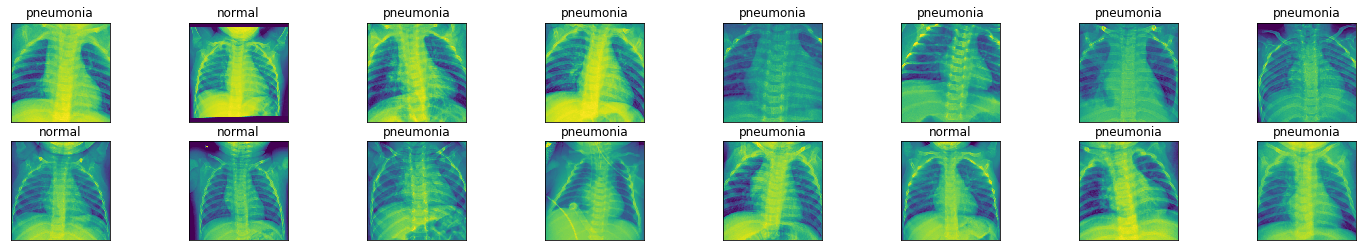

In [0]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(16):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

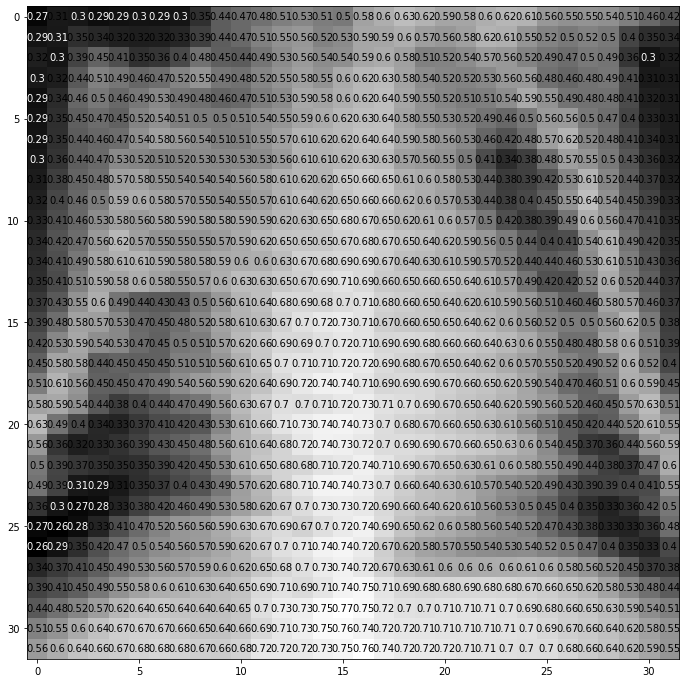

In [0]:
img = np.reshape(images[3], (448,448))
from skimage.transform import resize
img = resize(img, (32, 32))

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),horizontalalignment='center',verticalalignment='center',color='white' if img[x][y]<thresh else 'black')

---
## Define the Network

I spent quite a while experimenting with different network architectures before I found the one that showed satisfactory results in training. My final networks is 
Conv2d(1,16,3)
MaxPool(2,2)
Conv2d(16,32,3)
MaxPool(2,2)
Conv2d(32,64,3)
MaxPool(2,2)
Conv2d(64,128,3)
MaxPool(2,2)
Conv2d(128,256,3)
MaxPool(2,2)
Flatten(256*14*14)
Dropout(0.25)
FC(256*14*14, 256)
Dropout(0.25)
FC(256, 2)
Things worth exploring in my opinion:
-Using AveragePool instead of MaxPool
-Using larger kernels since it's a bigger image(448x448)
-Using Depthwise convolutions
-Increasing number of layers and adding residual connections

In [0]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layers
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        #fully connected layers
        self.fc1 = nn.Linear(256*14*14,256)
        self.fc2 = nn.Linear(256,2)
        self.dropout=nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        #print(x.shape)
        x = x.view(-1,256*14*14)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


### Specify Loss Function and Optimizer
I went with CrossEntropyLoss and Adam optimizer. It took me a while to find a suitable learning rate - the number turned out to be quite small in the end. I also tried BCELoss(binary classification loss) with sigmoid activation function for the last layer, but the results didn't meet my expectations.

In [0]:
import torch.optim as optim

# specify loss function

criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

---
## Train the Network

Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting.

In [0]:
# number of epochs to train the model
n_epochs = 30 # you may increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss
train_losses, test_losses = [], []

for epoch in range(1, n_epochs+1):
    print('Epoch: {}'.format(epoch))
    # keep track of training and validation loss
    running_loss = 0
    valid_loss = 0
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in Bar(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        running_loss += loss.item()
        
    ######################    
    # validate the model #
    ######################
    test_loss = 0
    accuracy = 0
    with torch.no_grad():
      model.eval()
      for images, labels in valid_loader:
        if train_on_gpu:
          images, labels = images.cuda(), labels.cuda()
        ps = model(images)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        test_loss += criterion(ps, labels)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
      train_losses.append(running_loss/len(train_loader))
      test_losses.append(test_loss/len(valid_loader))
      print("Training Loss: {:.3f}.. ".format(train_losses[-1]),
      "Test Loss: {:.3f}.. ".format(test_losses[-1]),
      "Test Accuracy: {:.3f}".format(accuracy/len(valid_loader)))
    
    # save model if validation loss has decreased
    if test_losses[-1] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        test_losses[-1]))
        torch.save(model.state_dict(), 'model_pneumonia.pt')
        valid_loss_min = test_losses[-1]

Epoch: 1
5216/5216: [===============================>] - ETA 0.5s
Training Loss: 0.241..  Test Loss: 0.750..  Test Accuracy: 0.562
Validation loss decreased (inf --> 0.749892).  Saving model ...
Epoch: 2
5216/5216: [===============================>] - ETA 0.6s
Training Loss: 0.122..  Test Loss: 0.736..  Test Accuracy: 0.562
Validation loss decreased (0.749892 --> 0.736423).  Saving model ...
Epoch: 3
5216/5216: [===============================>] - ETA 0.7s
Training Loss: 0.096..  Test Loss: 0.555..  Test Accuracy: 0.875
Validation loss decreased (0.736423 --> 0.554549).  Saving model ...
Epoch: 4
5216/5216: [===============================>] - ETA 0.7s
Training Loss: 0.088..  Test Loss: 0.560..  Test Accuracy: 0.812
Epoch: 5
3632/5216: [======================>.........] - ETA 57.4s

KeyboardInterrupt: ignored

###  Load the Model with the Lowest Validation Loss

In [0]:
model.load_state_dict(torch.load('model_pneumonia.pt'))

<All keys matched successfully>

---
## Test the Trained Network

Test your trained model on previously unseen data! For my model it has good accuracy for pneumonia and not so good for normal lungs. Well, better be cautious then negligent I guess :)

In [0]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.cpu()
model.eval()
# iterate over test data
for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.943894

Test Accuracy of normal: 38% (89/234)
Test Accuracy of pneumonia: 98% (385/390)

Test Accuracy (Overall): 75% (474/624)


### Visualize Sample Test Results

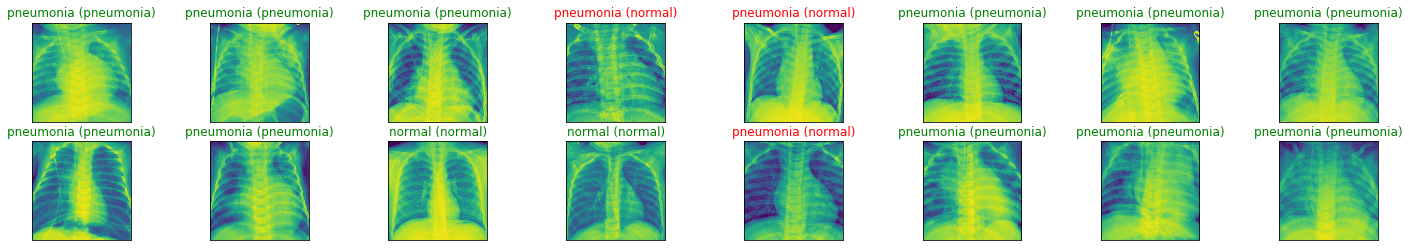

In [0]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

model.cpu()
# move model inputs to cuda, if GPU available

# get sample outputs
output = model(images)
#convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))